# Week 10 Assignment

In this week's lecture lab we examined two dimensionality reduction techniques, Principal Component Analysis (PCA) and the Autoencoder. In this assignment we will explore additional functionalities of the Autoencoder and demonstrate its incredible versatility.

# Part A - Imports and Data Prep

All required imports have been made for you.

In [1]:
# Import tensorflow - 
# You can use: 
# pip install tensorflow
# to install these packages
# make sure that you have seaborn version 0.11.0 installed 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy.random import normal
from tensorflow.keras.datasets.mnist import load_data
import tensorflow as tf
import random
from tqdm import tqdm
random.seed(100)
plt.style.use('seaborn')
from torch.utils.data import TensorDataset

# Part B - Noise Reduction

The autoencoder serves many purposes. You have already seen its ability to perform dimensionality reduction and now you will see how it can perform noise reduction. 

# Q1 List an additional functionality or potential use of an autoencoder (that has not been mentioned yet) in the space provided below. (5 marks)

Another field of application for autoencoders is anomaly detection. By learning to replicate the most salient features in the training data under some of the constraints selected, the model is encouraged to learn how to precisely reproduce the most frequent characteristics of the observations. When facing anomalies, the model should worsen its reconstruction performance. In most cases, only data with normal instances are used to train the autoencoder; in others, the frequency of anomalies is so small compared to the whole population of observations, that its contribution to the representation learnt by the model could be ignored. After training, the autoencoder will reconstruct normal data very well, while failing to do so with anomaly data which the autoencoder has not encountered. Reconstruction error of a data point, which is the error between the original data point and its low dimensional reconstruction, is used as an anomaly score to detect anomalies.

# Q2 (30 marks)
To illustrate the ability of our autoencoder to reduce noise we will be using image data. Use the `load_data` function with the path attribute set to "mnist.npz". (Check documentation: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) You only care about the image data so you need to extract the training images from the imported data and get rid of the labels. Ensure your pixel values are between 0 and 1 and save this to the variable X_2

To simulate a noisy image, we will be adding white Gaussian noise to the data. To do this, you will need to use the normal function with a mean of 0 and a variance of 0.1. Cycle through the images in X_2, add noise, and save to a variable called X_2_noise.

Display the first image in X_2 and the first image in X_2_noise to see the effect of the noise you added. You can use the `sns.imshow` function for this.

(60000, 28, 28)


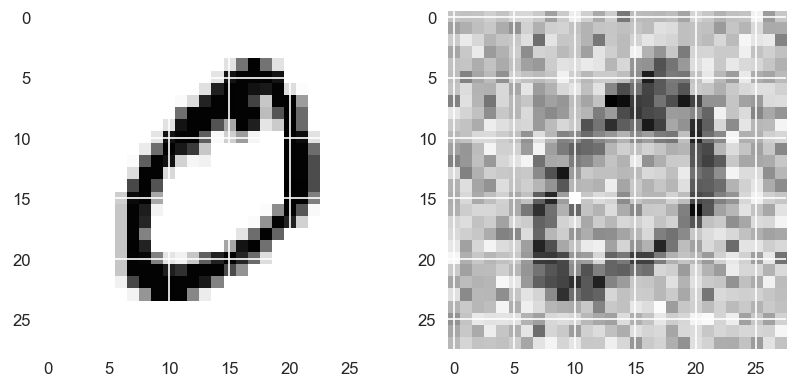

In [2]:
load_data(path='mnist.npz')

(train_images, _), (test_images, _) = load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28)) / 255.
    return images.astype('float32')
    #return np.where(images > .5, 1.0, 0.0).astype('float32')

X_2 = preprocess_images(train_images)
# X_2_test = preprocess_images(test_images)
print(X_2.shape)
# print(X_2_test.shape)


noise1 = np.random.normal(loc=0, scale =0.3, size = (60000, 28, 28))
X_2_noise = X_2+noise1
# noise2 = np.random.normal(loc=0, scale =0.3, size = (10000, 28, 28))
# X_2_noise_test = X_2_test+noise2

fig, (ax1, ax2) = plt.subplots(1,2, dpi =120)

ax1.imshow(X_2[1,:,:])
ax2.imshow(X_2_noise[1,:,:])


# Q3 Create an autoencoder to de-noise the image. You are responsible for selecting an appropriate design for the autoencoder. To speed up your training, for each iteration, train on a small subset of the data. (40 marks)

In this setting, it is useful to train a slight variation on the autoencoder that takes a noisy image as input and has the original (non-noisy) image as its target. You can then use this model to de-noise future images. Note that you will have to take care of re-shaping the images into tensors as you use the `from_numpy` function. 

In [7]:
#reshape,flatten, and convert data to tensor
#training
X_2_flat = X_2.reshape(len(X_2), -1)
X_2_tensor = torch.FloatTensor(X_2_flat)

X_2_flat_noise = X_2.reshape(len(X_2_noise), -1)
X_2_tensor_noise = torch.FloatTensor(X_2_flat_noise)

#testing
# X_2_flat_test = X_2_test.reshape(len(X_2_test), -1)
# X_2_tensor_test = torch.FloatTensor(X_2_flat_test)

# X_2_flat_noise_test = X_2_noise_test.reshape(len(X_2_noise_test), -1)
# X_2_tensor_noise_test = torch.FloatTensor(X_2_flat_noise_test)

#X_2_noise= torch.from_numpy(X_2_noise).float()
#X_2_noise_flat = torch.flatten(X_2_noise, start_dim=1)
#X_2= torch.from_numpy(X_2).float()
#X_2_flat = torch.flatten(X_2, start_dim=1)

# print (X_2_flat_noise.shape)
# print (X_2_flat.shape)

#creating an autoencoder model
class denoise(nn.Module):
  def __init__(self):
    super(denoise,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(784,128),
                  nn.ReLU(),
                  #nn.Sigmoid(),
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(128,784),
                  nn.Sigmoid(),
                  )
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

#model
autoencoder = denoise()

#define loss function
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-2

#random list of numbers from 1 to 60,000
X_2_list = [i for i in range (len(X_2))]

batch_size = 64
test_interval = 100

optimizer = torch.optim.Adam(autoencoder.parameters(), lr= learning_rate, weight_decay = 1e-5)

#train model
for t in range (5000):
    batch_indices = np.array(random.sample(X_2_list, batch_size))
    batch = X_2_tensor_noise[batch_indices]
    batch_target = X_2_tensor[batch_indices]
    
    y_pred = autoencoder(batch)
    loss = loss_fn(y_pred,batch_target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 1000 == 999:
        #y_pred = autoencoder(X_2_tensor_noise_test)
        #loss = loss_fn(y_pred,X_2_tensor_test)
        print(t, loss.item())

999 0.007758253253996372
1999 0.006571948528289795
2999 0.007320298347622156
3999 0.007341850083321333
4999 0.00768101355060935


# Q4 (25 marks)
### Pass the noisy images through your trained denoiser. (Often in practice we would evaluate a de-noiser using new test data, but to keep things simple for this assignment we will re-use the noised training data.)

### Plot histograms of the image noise (i.e. all of the pixel-by-pixel differences from the original image) before and after the use of the denoiser (You can use a subset of the data to reduce the time it takes to generate). 

### Display three images: an image of a noisy sample, an image of the sample after denoising, and an image the corresponding original (noise-free) sample.


Text(0.5, 1.0, 'Image Noise Before Denoise')

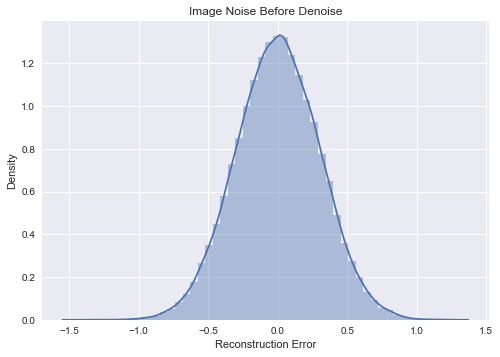

In [8]:
#pass scaled data to the autoencoder
X_reconstructed = autoencoder(X_2_tensor_noise[0:64,:])

#sns.distplot(X_2_tensor[0:64,:] - X_2_tensor_noise[0:64,:])
sns.distplot(X_2[0:64,:] - X_2_noise[0:64,:])

plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Image Noise Before Denoise")

Text(0.5, 1.0, 'Image Noise After Denoise')

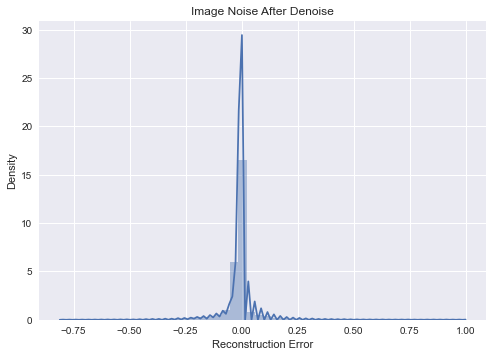

In [9]:
sns.distplot(X_2_tensor[0:64,:] - X_reconstructed.detach().numpy())

plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Image Noise After Denoise")


torch.Size([64, 784])


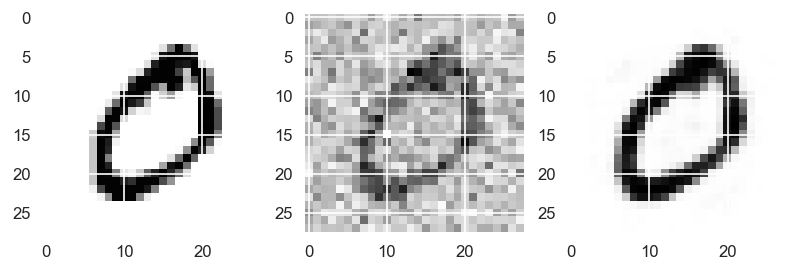

In [10]:
print(X_reconstructed.shape)
X_reconstructed2 = np.reshape(X_reconstructed.detach().numpy()[1,:], (28, 28))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi= 120)

ax1.imshow(X_2[1,:,:])
ax2.imshow(X_2_noise[1,:,:])
ax3.imshow(X_reconstructed2)

# Congratulations you have completed this week's assignment. Please remember to restart and run all cells before submitting.